In [96]:
from gensim import models, corpora, similarities 
from tqdm import tqdm
import json
import os
import re

In [458]:
DOC2VEC_FILES_PATH = "/home/jack/datasets/polish_rap/d2v_files/"
DOC2VEC_CONFIG_PATH = "/home/jack/datasets/polish_rap/d2v_config/"

RAPPERS_PATH = "/home/jack/datasets/polish_rap/stm_lyrics/"

BASE_PATH = "/home/jack/datasets/polish_rap/"

In [358]:
# ?Doc2Vec

In [465]:
# preprocess files for Doc2Vec
# documents are dynamically constructed from rappers' lyrics

def preprocess_documents(rappers_list):
    if not os.path.exists(DOC2VEC_FILES_PATH): 
        os.mkdir(DOC2VEC_FILES_PATH)
    
    for rapper in tqdm(rappers_list):
        rapper_allsongs = ""
        songs = os.listdir(RAPPERS_PATH + rapper)
        for song in songs:
            with open(RAPPERS_PATH + rapper + "/" + song, "r") as f:
                song_text = json.load(f)
            rapper_allsongs += song_text["lyrics"]
        re.sub("\s\n\s\n", "\n", rapper_allsongs) # it doesn't work, i have no idea why!!!
        with open(DOC2VEC_FILES_PATH + rapper, "w") as f:
            f.write(rapper_allsongs)

In [466]:
def get_populars():
    with open(DOC2VEC_CONFIG_PATH + "popular_rappers.json", "r") as f:
        popular_rappers_frame = json.load(f)
    return popular_rappers_frame["allwords"].keys()

In [467]:
import itertools

def head(d):
    return dict(itertools.islice(d.items(), 10))

In [468]:
popular_rappers = get_populars()

In [469]:
popular_rappers = list(popular_rappers)
popular_rappers.remove("Wbw")
popular_rappers.remove("Mickiewicz")

In [471]:
popular_rappers

['Paluch',
 'Slums',
 'Grubson',
 'Abradab',
 'Onar',
 'Kartky',
 'Kuba-Knap',
 'Eldo',
 'Ten-Typ-Mes',
 'Quebonafide',
 'Huczuhucz',
 'Deys',
 'Bonson',
 'Kajman',
 'Peerzet',
 'Ona',
 'Vixen',
 'Sobota',
 'Laikike1',
 'Buka',
 'Oxon',
 'Eripe',
 'Biaas',
 'Filipek',
 'Bezczel',
 'Tede',
 'Wdowa',
 'Solar',
 'Te-Tris']

In [472]:
preprocess_documents(popular_rappers)

### Doc2Vec
from http://radimrehurek.com/gensim/tut1.html

In [473]:
def get_lyrics_docs():
    rappers_list = os.listdir(DOC2VEC_FILES_PATH)
    for rapper in rappers_list:
        with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
            lyrics = f.read()
        yield lyrics.split()

In [474]:
dictionary = corpora.Dictionary(get_lyrics_docs())

In [475]:
print(dictionary)

Dictionary(39270 unique tokens: ['egoizmuboli', 'braka', 'skan', 'przetkać', 'longboardem']...)


In [476]:
dictionary.save(DOC2VEC_CONFIG_PATH + "doc2vec.dict")

In [477]:
head(dictionary.token2id)

{'braka': 15136,
 'camo': 32450,
 'egoizmuboli': 38682,
 'longboardem': 32446,
 'opowiadać': 4,
 'przetkać': 26359,
 'rozpuszczać': 19503,
 'sgh': 34451,
 'skan': 38683,
 'sugerować': 17918}

In [478]:
def get_corpus():
    for t in get_lyrics_docs():
        yield dictionary.doc2bow(t)

In [479]:
corpora.MmCorpus.serialize(DOC2VEC_CONFIG_PATH + "d2v.mm" , get_corpus())

In [480]:
tfidf = models.TfidfModel(corpus)

In [481]:
corpus_tfidf = tfidf[corpus]

In [482]:
print(corpus_tfidf[0])

[(0, 0.008634899542299575), (1, 0.0007739831980240726), (2, 0.007176591429949005), (3, 0.019926477887737024), (4, 0.003980027060740798), (5, 0.003061934655466792), (7, 0.0014851105775286284), (8, 0.0031544500695108763), (9, 0.015904336527298894), (10, 0.0034861245346900845), (11, 0.011882195166860765), (12, 0.0005708108159853545), (13, 0.0003805405439902364), (15, 0.010587354861327256), (16, 0.003837912445984509), (17, 0.0017718504642699549), (18, 0.02376439033372153), (19, 0.023063790909307234), (20, 0.002404944603164985), (22, 0.007860053806422638), (24, 0.002259956313405566), (25, 0.019926477887737024), (26, 0.06775767329421507), (27, 0.009225516363722893), (28, 0.019189562229922547), (29, 0.013130427001778255), (31, 0.005086144280901998), (32, 0.0014851105775286284), (33, 0.003464144495551415), (34, 0.004612758181861447), (35, 0.019926477887737024), (36, 0.004212411632433247), (37, 0.009529393298404886), (38, 0.010085572491187453), (39, 0.015351649783938036), (40, 0.005086144280901

### VERY PAINFUL

In [519]:
def flatten(l):
    return [subsub for sub in l for subsub in sub]

In [530]:
rappers_mapping = {}
def construct_lyrics_docs():
    os.remove(DOC2VEC_CONFIG_PATH + "d2v.docs")
    rappers_list = os.listdir(DOC2VEC_FILES_PATH)
    for uid, rapper in enumerate(rappers_list):
        with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
            l = f.read()
        lt = "".join([word for word in flatten(l.split("\n"))])
        lt += "\n"
        with open(DOC2VEC_CONFIG_PATH + "d2v.docs", "a") as f:
            f.write(lt)
        rappers_mapping[uid] = rapper

In [524]:
flatten([[1,2], [3,4]])

[1, 2, 3, 4]

In [531]:

construct_lyrics_docs()

In [532]:
class LabeledLineSentence(object):
    def __init__(self, filename):
        self.filename = filename
    def __iter__(self):
        for uid, line in enumerate(open(filename)):
            yield LabeledSentence(words=line.split(), labels=["RAPPER_"+str(uid)])

In [533]:
tagged = models.doc2vec.TaggedLineDocument(DOC2VEC_CONFIG_PATH + "d2v.docs")

In [534]:
model = Doc2Vec(tagged, size=100, window=8, min_count=5, workers=4)

In [535]:
model.save(DOC2VEC_CONFIG_PATH + "d2v.model")

In [536]:
def get_lyrics(rapper):
    with open(DOC2VEC_FILES_PATH + rapper, "r") as f:
        return f.read().split()

In [537]:
# model.n_similarity("SENT_%1", "SENT_%2")
model.docvecs.most_similar(1)[0][0]

0

In [538]:
inv_rappers_mapping = {v: k for k, v in rappers_mapping.items()}

In [539]:
def sim(rapper1, rapper2):
    return model.docvecs.similarity(inv_rappers_mapping[rapper1], inv_rappers_mapping[rapper2])

In [540]:
rappers_mapping

{0: 'Bezczel',
 1: 'Grubson',
 2: 'Vixen',
 3: 'Kartky',
 4: 'Wdowa',
 5: 'Deys',
 6: 'Biaas',
 7: 'Huczuhucz',
 8: 'Kuba-Knap',
 9: 'Bonson',
 10: 'Sobota',
 11: 'Filipek',
 12: 'Oxon',
 13: 'Ona',
 14: 'Eldo',
 15: 'Te-Tris',
 16: 'Buka',
 17: 'Ten-Typ-Mes',
 18: 'Eripe',
 19: 'Quebonafide',
 20: 'Onar',
 21: 'Kajman',
 22: 'Peerzet',
 23: 'Abradab',
 24: 'Solar',
 25: 'Tede',
 26: 'Slums',
 27: 'Laikike1',
 28: 'Paluch'}

In [541]:
for i in popular_rappers:
    if i in inv_rappers_mapping.keys():
        print(i, rappers_mapping[model.docvecs.most_similar(inv_rappers_mapping[i])[0][0]])

Paluch Slums
Slums Paluch
Grubson Bezczel
Abradab Onar
Onar Abradab
Kartky Vixen
Kuba-Knap Bonson
Eldo Te-Tris
Ten-Typ-Mes Ona
Quebonafide Eripe
Huczuhucz Bonson
Deys Filipek
Bonson Huczuhucz
Kajman Peerzet
Peerzet Eripe
Ona Ten-Typ-Mes
Vixen Kartky
Sobota Ona
Laikike1 Peerzet
Buka Te-Tris
Oxon Bezczel
Eripe Peerzet
Biaas Deys
Filipek Deys
Bezczel Grubson
Tede Solar
Wdowa Peerzet
Solar Biaas
Te-Tris Eldo


### Reduce the dimensionality for plotting

In [542]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)


In [543]:
RAPPER_NUM = len(popular_rappers)

In [550]:
new_rappers = tsne_model.fit_transform([a for a in model.docvecs])
new_rappers *= 10e5

In [552]:
print(new_rappers)

[[ 176.11513182   39.97016907]
 [  97.67882669  223.41953891]
 [ 186.28481218  -97.44721569]
 [  94.91938453  -15.09370175]
 [ -10.32699284   41.08030985]
 [  14.38004701  145.24285585]
 [  76.06778107   12.20051397]
 [  44.33133261   33.38102748]
 [ 149.14542086  -20.47703921]
 [  31.23124767  -85.3280232 ]
 [-254.50139478   65.18407976]
 [  86.26374313  -74.12396937]
 [ 226.25304397 -145.0289687 ]
 [   4.59084042  -18.71564115]
 [ 152.87567506  146.6866972 ]
 [  15.4557193    37.83146994]
 [ -88.54739191 -197.47085099]
 [ -34.80304842   15.66006844]
 [ 122.74747194  120.06667871]
 [ -38.72024215  -30.23171126]
 [-104.56443893 -141.63518373]
 [-170.01543906  194.58906859]
 [ -50.87918606  -43.80156849]
 [-125.07397755   77.61726012]
 [-160.97298589  -21.15964286]
 [ -89.4838667    38.6974291 ]
 [ -50.97468409 -117.96403539]
 [  -2.84269493   42.78622041]
 [   6.62798092   30.27050842]]


In [553]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

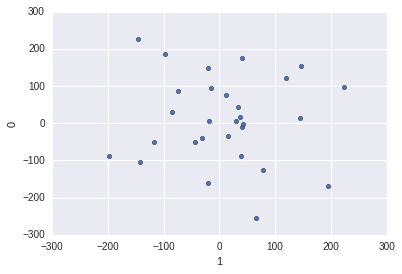

In [554]:
pd.DataFrame(new_rappers).plot(kind="scatter", x=1, y=0)

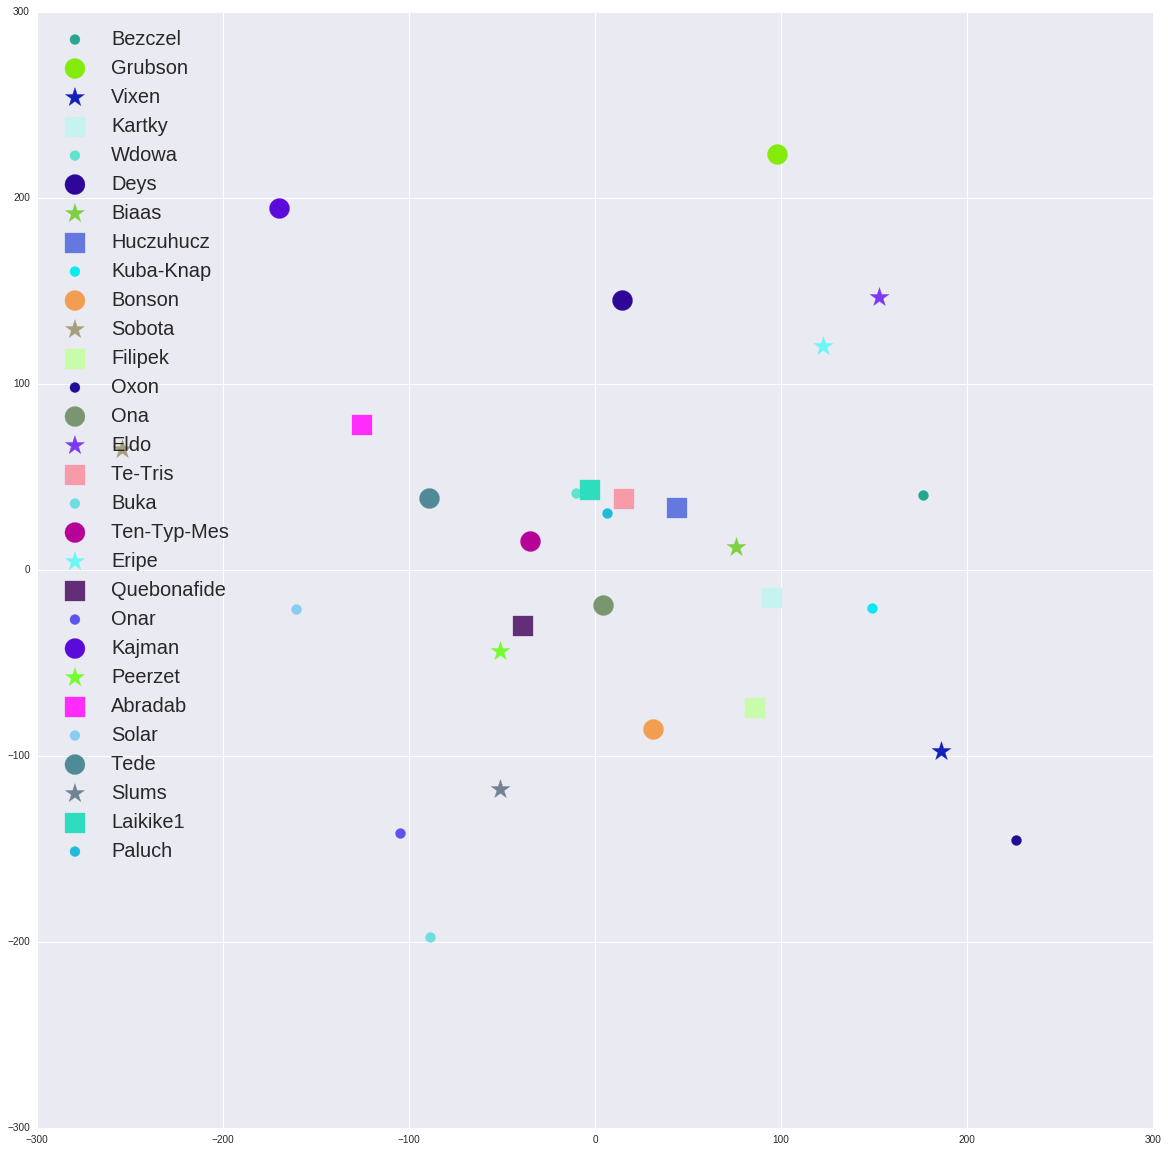

In [555]:
import numpy as np

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1,1,1)
marker = itertools.cycle((',', '.', 'o', '*'))
print(marker, next(marker))
for r in range(RAPPER_NUM):
    ax.scatter(new_rappers[r][0], new_rappers[r][1], color=np.random.rand(3,1), marker=next(marker), label=rappers_mapping[r], s=400)
ax.legend(loc=2, prop={'size':20})
plt.show()

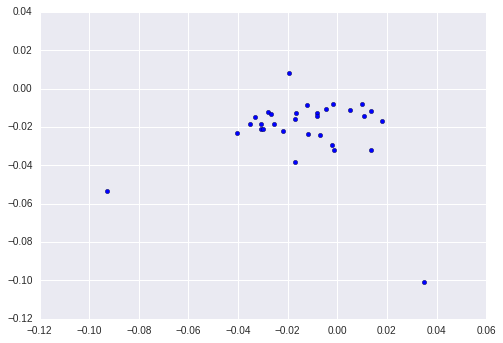

In [300]:
plt.scatter(x=new_rappers.transpose()[0], y=new_rappers.transpose()[1], label=[rappers_mapping[i] for i in range(31)])